## Interpretability Script!
This script is to explore the relative contributions of the MJO & ENSO (indices) to prediction of z500 in the North Pacific (part of the PNA) 

## Prep for analysis

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import random 
from datetime import datetime
import pandas as pd

import sys
sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/utils/')
from exp_hp import get_hp
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results
sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/interpret/')
from Gordon_interp import getoutputvecs, confvacc, iconfcorr


# import importlib
# importlib.reload(sys.modules["Gordon_interp"])
# from Gordon_interp import getoutputvecs, confvacc, iconfcorr
# importlib.reload(sys.modules["trainGordon_utils"])
# from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

2023-08-24 09:52:58.994382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 09:52:59.225138: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-24 09:52:59.963982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/int

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

In [14]:
DIR = '/glade/scratch/kjmayer/DATA/CESM2-piControl/daily/'
MODEL_DIR = '/glade/scratch/wchapman/'

X1_FINAME = 'SSTv2_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
X2_FINAME = 'MJO_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
Y_FINAME  = 'Z500v2_CESM2_0100_0400.b.e21.B1850.f09_g17.CMIP6-esm-piControl.001.nc'
MODEL_FINAME = 'exp_7days.h5'

EXP_NAME = 'exp1'
hps = get_hp(EXP_NAME)

N_z500runmean = hps['Y_RUNMEAN'] #days
N_days_100yrs = 100*365 #days
LEAD = hps['LEAD'] #days

N_daysbefore = hps['X_ADDITIONAL_DAYS'] #days to go "back in time" for X

X1VAR = 'TS_SST_ONI'
X2VAR1 = 'RMM1_CESM2'
X2VAR2 = 'RMM2_CESM2'

YVAR = 'TS_Z500a'

GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

### Prep data:

In [15]:
# TRAINING (100 years)
# predictors [time]
X1train = xr.open_dataset(DIR+X1_FINAME)[X1VAR][:N_days_100yrs]

X2trainRMM1 = xr.open_dataset(DIR+X2_FINAME)[X2VAR1][:N_days_100yrs]
X2trainRMM2 = xr.open_dataset(DIR+X2_FINAME)[X2VAR2][:N_days_100yrs]
X2train = xr.concat([X2trainRMM1,X2trainRMM2], dim = 'new_dim') # 2xtime
del X2trainRMM1, X2trainRMM2

# predictand [time]
Ytrain = xr.open_dataset(DIR+Y_FINAME)[YVAR][:N_days_100yrs]


# VALIDATION (100 years)
# repeat for validation data
X1test = xr.open_dataset(DIR+X1_FINAME)[X1VAR][N_days_100yrs*2:]

X2testRMM1 = xr.open_dataset(DIR+X2_FINAME)[X2VAR1][N_days_100yrs*2:]
X2testRMM2 = xr.open_dataset(DIR+X2_FINAME)[X2VAR2][N_days_100yrs*2:]
X2test = xr.concat([X2testRMM1,X2testRMM2], dim = 'new_dim') # 2xtime

# predictand [time]
Ytest = xr.open_dataset(DIR+Y_FINAME)[YVAR][N_days_100yrs*2:]

In [16]:
_DAYS_IN_MONTH = [31,28,31,30,31,30,31,31,30,31,30,31]  # Ignores leap days.

# ----------------
start_year, end_year = int(Ytrain.time.dt.year[0]), int(Ytrain.time.dt.year[-1])+1
dates = []
for year in range(start_year, end_year):
    for month in range(1, 13):
        for day in range(1, _DAYS_IN_MONTH[month-1]+1):
            dates.append(datetime(year, month, day, hour=0, minute=0))

dates = pd.to_datetime(dates)
dates_a2a = dates[119:(36500+119)]

Ytrainroll = Ytrain.rolling(time=N_z500runmean, min_periods=N_z500runmean, center=False).mean('time').dropna('time')
Ytrainroll['time'] = dates_a2a[:-(N_z500runmean-1)]

# -----------------
start_year, end_year = int(Ytest.time.dt.year[0]), int(Ytest.time.dt.year[-1])+1
dates = []
for year in range(start_year, end_year):
    for month in range(1, 13):
        for day in range(1, _DAYS_IN_MONTH[month-1]+1):
            dates.append(datetime(year, month, day, hour=0, minute=0))

dates = pd.to_datetime(dates)
dates_a2a = dates[119:(36500+119)]

Ytestroll = Ytest.rolling(time=N_z500runmean, min_periods=N_z500runmean, center=False).mean('time').dropna('time')
Ytestroll['time'] = dates_a2a[:-(N_z500runmean-1)]

In [17]:
# end X early, so we don't run out of Y data
X1train_final = X1train[:-(N_z500runmean-1)][:-1*LEAD] 
X2train_final = X2train[:,:-(N_z500runmean-1)][:,:-1*LEAD] 

# shift Y to account for lead
Ytrain_final = Ytrainroll[LEAD:]


# repeat for testing data
# end X early, so we don't run out of Y data
X1test_final = X1test[:-(N_z500runmean-1)][:-1*LEAD] 
X2test_final = X2test[:,:-(N_z500runmean-1)][:,:-1*LEAD] 

# shift Y to account for lead
Ytest_final = Ytestroll[LEAD:]

In [18]:
# check that Y and X1/2 are the same size
print(X1train_final.shape)
print(X2train_final.shape)
print(Ytrain_final.shape)

print(X1test_final.shape)
print(X2test_final.shape)
print(Ytest_final.shape)

(36487,)
(2, 36487)
(36487,)
(36368,)
(2, 36368)
(36368,)


In [19]:
# NOTE: we standardize training, validation and testing using the TRAINING mean & std (or median)

# standardize Xs using Xtrain
# ----- code here -----
X1mean = X1train_final.groupby('time.dayofyear').mean()
X1std = X1train_final.groupby('time.dayofyear').std()
X2mean = X2train_final.groupby('time.dayofyear').mean()
X2std = X2train_final.groupby('time.dayofyear').std()

# preprocess Ys by subtracting Ytrain median
# ----- code here -----
Ymed = Ytrain_final.quantile(q=.5,dim='time')


# TESTING STANDARDIZATION
# standardize Xs using Xtrain
X1test_norm = (X1test_final.groupby('time.dayofyear')- X1mean).groupby('time.dayofyear')/(X1std)
X2test_norm = (X2test_final.groupby('time.dayofyear')- X2mean).groupby('time.dayofyear')/(X2std)

# preprocess Ys by subtracting Ytrain median
# ----- code here -----
Ytest_norm = Ytest_final - Ymed

# turn Ys into 0s and 1s
# ----- code here -----
Ytest_norm[Ytest_norm<=0] = 0 
Ytest_norm[Ytest_norm>0] = 1

In [20]:
# subset predictand (and predictors) to same number of 0s and 1s
    # if you subtract Ytrain median from Ytrain, you will have balanced classes, by definition
    # therefore, you only need to subset validation (& eventually testing) data to have balanced classes
n_testzero = np.shape(np.where(Ytest_norm==0)[0])[0]
n_testone  = np.shape(np.where(Ytest_norm==1)[0])[0]
i_testzero = np.where(Ytest_norm==0)[0]
i_testone  = np.where(Ytest_norm==1)[0]

# look into the "subset" function and learn how it works
X1test_norm, Ytest_norm, i_testnew = subset(X1test_norm, Ytest_norm, n_testzero, n_testone, i_testzero, i_testone)
X2test_norm = X2test_norm.isel(time = i_testnew,drop=True)

In [21]:
# convert data from xarray to numpy (xarray takes ALOT longer to train with than numpy)
X1_test = X1test_norm.T.values
X2_test = X2test_norm.T.values

Y_test = Ytest_norm.values

In [22]:
#clunky bad loop: 
for ee,num in enumerate(reversed(range(N_daysbefore + 1))):
    X1_test_back = X1_test[num:-(ee+1)] 
    X2_test_back = X2_test[num:-(ee+1),:]
    if ee==0:
        X1_test_norm_mem=X1_test[num:-(ee+1)]
        X2_test_norm_mem=X2_test[num:-(ee+1),:]
    else: 
        X1_test_norm_mem = np.vstack([X1_test_back,X1_test_norm_mem])
        X2_test_norm_mem = np.concatenate([X2_test_back,X2_test_norm_mem],axis=1)
        
Y_test_mem=Y_test[N_daysbefore:-1] #adjust Ytarget.... 
X1_test_norm_mem = X1_test_norm_mem.T

### Load network:

In [23]:
# variables:
SEED = 1
DROPOUT_RATE = hps['DROPOUT_RATE']

MODELNAME1 = 'ENSO'
RIDGE1 = hps['RIDGE1']
HIDDENS1 = hps['HIDDENS1']
INPUT_SHAPE1 = np.shape(X1_test_norm_mem)[1:][0]

MODELNAME2 = 'MJO'
RIDGE2 = hps['RIDGE2']
HIDDENS2 = hps['HIDDENS2']
INPUT_SHAPE2 = np.shape(X2_test_norm_mem)[1:][0]

BATCH_SIZE = hps['BATCH_SIZE']
N_EPOCHS = 10000
PATIENCE = hps['PATIENCE'] # number of epochs of no "improvement" before training is stopped
LR = hps['LR'] # learning rate


In [24]:
# ENSO MODEL
model1, input1 = build_model(SEED,
                             DROPOUT_RATE,
                             RIDGE1,
                             HIDDENS1,
                             INPUT_SHAPE1,
                             MODELNAME1)


# MJO MODEL
model2, input2 = build_model(SEED,
                             DROPOUT_RATE,
                             RIDGE2,
                             HIDDENS2,
                             INPUT_SHAPE2,
                             MODELNAME2)   

# COMBINE ENSO & MJO MODEL
model = fullmodel(model1, model2,
                  input1, input2,
                  SEED)

In [25]:
# load model weights here!
model.load_weights(MODEL_DIR+MODEL_FINAME)

## Interpret:

### How does the network perform on testing data?

In [26]:
rawpred = model.predict((X1_test_norm_mem,X2_test_norm_mem))
conf = np.max(rawpred,axis=-1)
predval = np.argmax(rawpred,axis=-1)

1101/1101 [==============================] - 1s 803us/step


In [27]:
rawpred

array([[0.5800173 , 0.41998267],
       [0.575208  , 0.42479196],
       [0.5639684 , 0.43603164],
       ...,
       [0.43195805, 0.5680419 ],
       [0.42211676, 0.57788324],
       [0.4101687 , 0.58983123]], dtype=float32)

In [28]:
predval

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
conf

array([0.5800173 , 0.575208  , 0.5639684 , ..., 0.5680419 , 0.57788324,
       0.58983123], dtype=float32)

In [30]:
# is it more accurate at higher confidence?
conf_acc, conf_percision, conf_recall = confvacc(confval = conf,
                                                 predval = predval,
                                                 Ytest   = Y_test_mem)

In [31]:
Y_test_mem

array([1., 1., 1., ..., 0., 0., 0.])

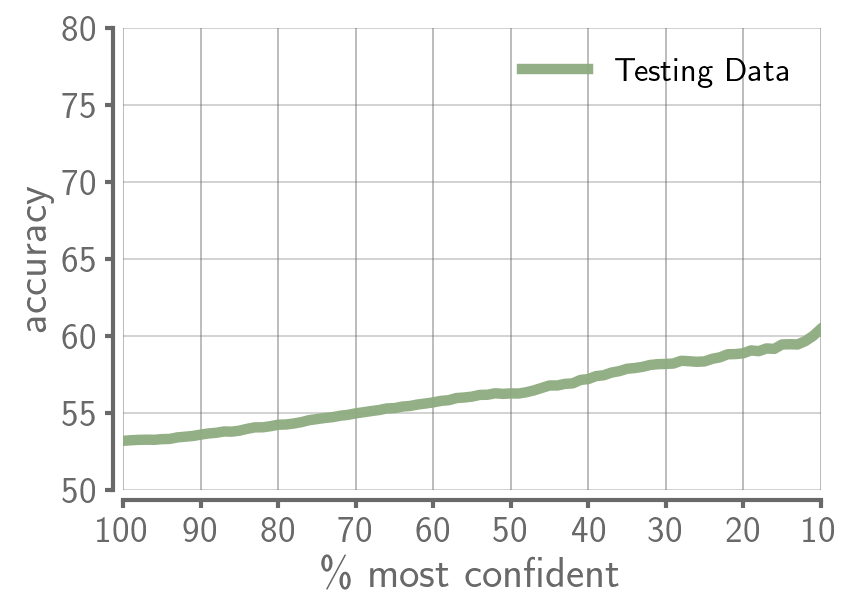

In [32]:
valColor = (141/255,171/255,127/255,1.)
FS = 18
plt.figure(figsize=(6, 4))

#---------- plot loss -------------------
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)


plt.plot(conf_acc, '-', color=valColor, alpha=0.95,linewidth=5,label='Testing Data')

plt.xlabel('\% most confident',fontsize=FS+3,color='dimgrey')
plt.ylabel('accuracy',fontsize=FS+3,color='dimgrey')
plt.xticks(np.arange(0,110,10),labels=np.arange(0,100+10,10)[::-1],fontsize=FS,color='dimgrey')
plt.yticks(np.arange(50,85,5),labels=np.arange(50,85,5),fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-2, loc='best',ncol=2)
plt.xlim(0, 90)
plt.ylim(50,80)

plt.show()

### Let's look at last layer model contributions:

In [33]:
model1_contribution, model2_contribution = getoutputvecs(model,
                                                         model1,
                                                         model2,
                                                         X1_test_norm_mem,
                                                         X2_test_norm_mem)

# model 1 winning class (model 1 output * weight)
model1pred = np.argmax(model1_contribution,axis=1)
# model 2 winning class (model 2 output * weight)
model2pred = np.argmax(model2_contribution,axis=1)

1101/1101 [==============================] - 1s 747us/step


In [34]:
print('--- ENSO Model Contribution to Final Layer ---')
print(model1_contribution[:10])
print(model1pred[:10])
print('\n--- MJO Model Contribution to Final Layer ---')
print(model2_contribution[:10])
print(model2pred[:10])

--- ENSO Model Contribution to Final Layer ---
[[-0.01024153  0.00934543]
 [-0.00976424  0.00891173]
 [-0.00927284  0.00846474]
 [-0.00876654  0.00800358]
 [-0.00825641  0.00753869]
 [-0.00775641  0.00708274]
 [-0.00727632  0.00664458]
 [-0.00681625  0.00622391]
 [-0.00637566  0.00582035]
 [-0.00595331  0.00543305]]
[1 1 1 1 1 1 1 1 1 1]

--- MJO Model Contribution to Final Layer ---
[[ 0.12366319 -0.21876822]
 [ 0.11310674 -0.2087014 ]
 [ 0.09220285 -0.18281816]
 [ 0.07768945 -0.16551384]
 [ 0.08075444 -0.17072034]
 [ 0.11500785 -0.21717343]
 [ 0.12530015 -0.22739126]
 [ 0.09974516 -0.18306272]
 [ 0.04940353 -0.0994596 ]
 [-0.02036844  0.00814486]]
[0 0 0 0 0 0 0 0 0 1]


In [35]:
# Where ENSO model (model 1), ...  
i_model1corr = model1pred==Y_test_mem
# ... MJO model (model 2), ...
i_model2corr = model2pred==Y_test_mem
# ... and final/total model are correct
i_modelcorr  = predval==Y_test_mem

In [36]:
# model (raw/confidence) values when correct
model1_corr = model1_contribution[i_model1corr] # these are NOT "confidence" - no softmax value
model2_corr = model2_contribution[i_model2corr] # these are NOT "confidence" - no softmax value
model_corr  = rawpred[i_modelcorr]

In [37]:
# terminology: "win" = modelX prediction is also (correct) full model prediction

# model 1 correct & model correct (model 2 not correct)
i_model1win = i_model1corr & i_modelcorr & ~i_model2corr
# model 2 correct & model correct (model 1 not correct)
i_model2win = i_model2corr & i_modelcorr & ~i_model1corr

# model 1&2 correct & model correct
i_model12win = i_model1corr & i_model2corr & i_modelcorr

In [38]:
# For correct predictions: model(X) values & predicted class when also full model prediction
model1win_contribution = model1_contribution[i_model1win]
model1win_predval = model1pred[i_model1win]

model2win_contribution = model2_contribution[i_model2win]
model2win_predval = model2pred[i_model2win]

model12win_predval = rawpred[i_model12win]

In [39]:
# these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
model_corr.shape[0] == model1win_predval.shape[0] + model2win_predval.shape[0] + model12win_predval.shape[0]

True

In [40]:
# Percentage of model predictions correct due to just ENSO:
model1_fracpred = (model1win_predval.shape[0]/model_corr.shape[0]) *100
print('Percentage of predictions correct due to only ENSO: \n'+str(np.round(model1_fracpred,2))+'%')
# Percentage of model predictions correct due to just MJO:
model2_fracpred = (model2win_predval.shape[0]/model_corr.shape[0]) *100
print('Percentage of predictions correct due to only MJO: \n'+str(np.round(model2_fracpred,2))+'%')

# Percentage of model predictions correct from ENSO & MJO:
model12_fracpred = (model12win_predval.shape[0]/model_corr.shape[0]) *100
print('Percentage of predictions correct due to ENSO & MJO: \n'+str(np.round(model12_fracpred,2))+'%')

Percentage of predictions correct due to only ENSO: 
28.1%
Percentage of predictions correct due to only MJO: 
23.82%
Percentage of predictions correct due to ENSO & MJO: 
48.07%


In [42]:
model1_plot = model1pred
model2_plot = model2pred

truth_plot = np.copy(Y_test_mem)
truth_plot[truth_plot==0] += 0.25
truth_plot[truth_plot==1] -= 0.25

model1_plot = model1_plot.astype(float)
model1_plot[model1_plot==0] += 0.125
model1_plot[model1_plot==1] -= 0.125

In [44]:
model1_plot.astype(float)

array([0.875, 0.875, 0.875, ..., 0.875, 0.875, 0.875])

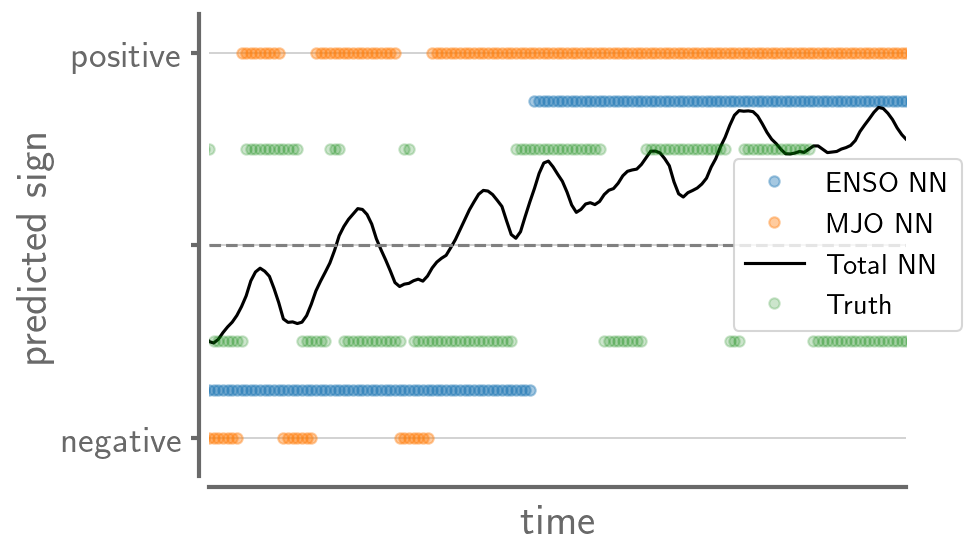

In [45]:
#---------------------------------------------------
valColor = (141/255,171/255,127/255,1.)
FS = 18

#---------- plot prediction = 0 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_plot,linewidth=0,marker='.',markersize=10,alpha=0.4,label='ENSO NN')
plt.plot(model2_plot,linewidth=0,marker='.',markersize=10,alpha=0.4,label='MJO NN')
plt.plot(rawpred[:,1],'k',label='Total NN') # when >0.5 - network predicts postive
plt.plot(truth_plot,'g',linewidth=0,marker='.',markersize=10,alpha=0.2,label='Truth')
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted sign',fontsize=FS+3,color='dimgrey')
# plt.title('...',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(0,1.5,0.5),labels=['negative','','positive'],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=True, fontsize=FS-4, bbox_to_anchor=(1.1, 0.5),ncol=1)
plt.xlim(700, 850)
plt.ylim(-0.1,1.1)

# SAVE ME!!!!!!!

plt.show()


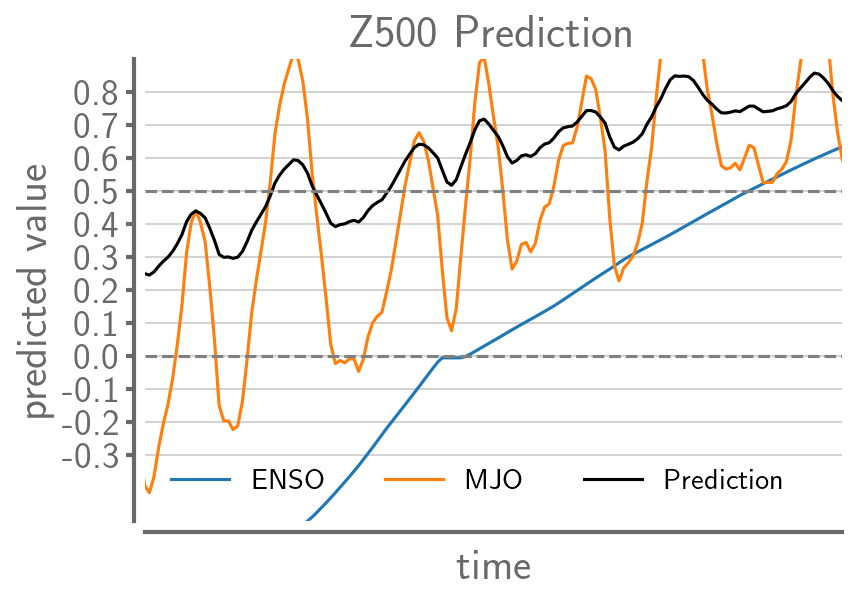

In [46]:
# NOT USING THIS FOR POSTER/PRESENTATION:
# Plot model 1 and model 2 contributions to (values summed to get) output before softmax

model1_diff = model1_contribution[:,1] - model1_contribution[:,0]
model2_diff = model2_contribution[:,1] - model2_contribution[:,0]

#---------------------------------------------------
valColor = (141/255,171/255,127/255,1.)
FS = 18

#---------- plot prediction = 0 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_diff,label='ENSO')
plt.plot(model2_diff,label='MJO')
plt.axhline(xmin=0,xmax=500,y=0.0,linestyle='--',color='grey')
plt.plot(rawpred[:,1],'k',label='Prediction') # when >0.5 - network predicts postive
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted value',fontsize=FS+3,color='dimgrey')
plt.title('Z500 Prediction',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(-0.3,0.9,0.1),labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-4, loc='best',ncol=3)
plt.xlim(700, 850)
plt.ylim(-.5,.9)
plt.show()

### UNCLEAR IF USEFUL:

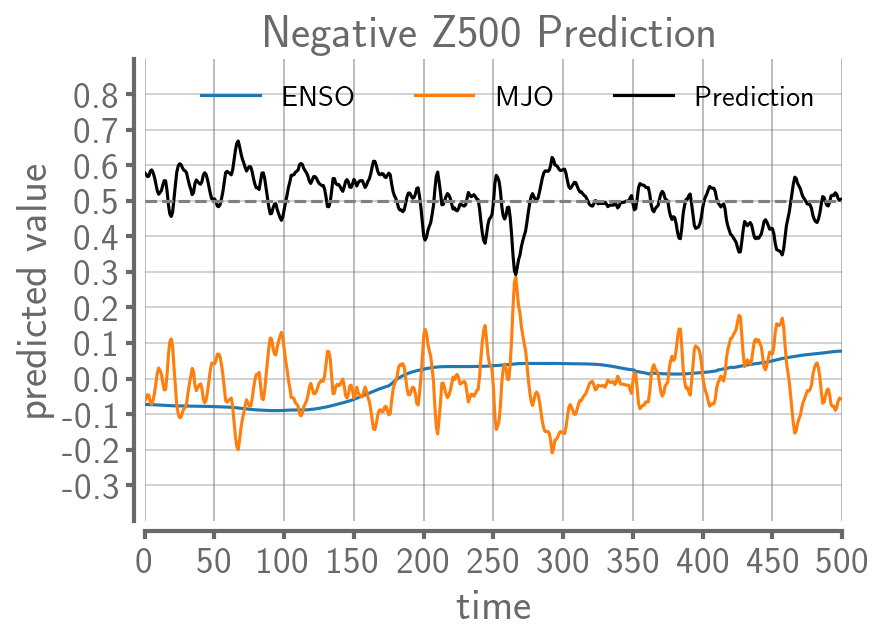

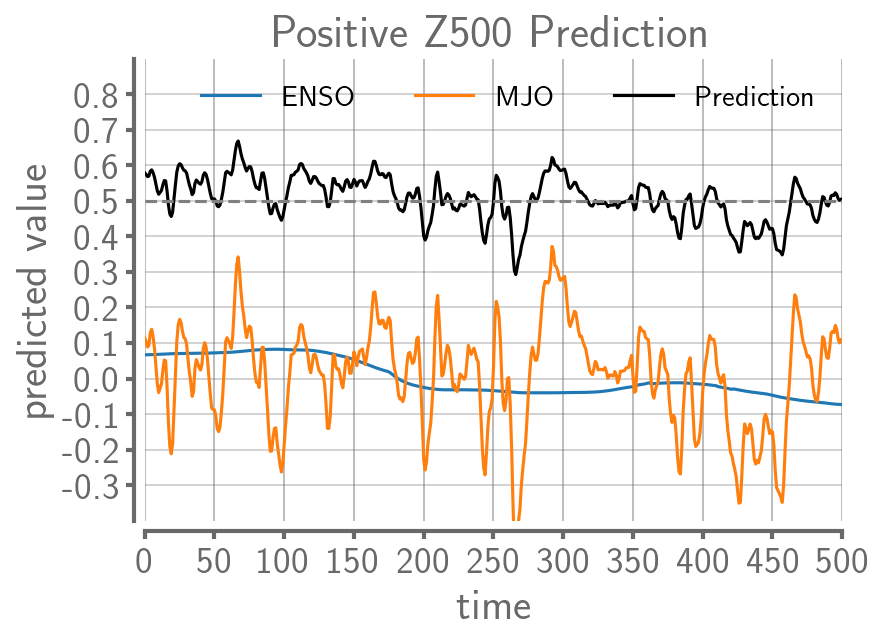

In [95]:
# Plot model 1 and model 2 contributions to (values summed to get) output before softmax

model1_lowval = model1_contribution[:500,0]
model2_lowval = model2_contribution[:500,0]

model1_highval = model1_contribution[:500,1]
model2_highval = model2_contribution[:500,1]

#---------------------------------------------------
valColor = (141/255,171/255,127/255,1.)
FS = 18

#---------- plot prediction = 0 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_lowval,label='ENSO')
plt.plot(model2_lowval,label='MJO')
plt.plot(rawpred[:500,1],'k',label='Prediction') # when >0.5 - network predicts postive
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted value',fontsize=FS+3,color='dimgrey')
plt.title('Negative Z500 Prediction',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(-0.3,0.9,0.1),labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-4, loc='best',ncol=3)
plt.xlim(0, 500)
plt.ylim(-.4,.9)
plt.show()


#---------- plot prediction=1 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_highval,label='ENSO')
plt.plot(model2_highval,label='MJO')
plt.plot(rawpred[:500,1],'k',label='Prediction') # when >0.5 - network predicts postive
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted value',fontsize=FS+3,color='dimgrey')
plt.title('Positive Z500 Prediction',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(-0.3,0.9,0.1),labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-4, loc='best',ncol=3)
plt.xlim(0, 500)
plt.ylim(-.4,.9)
plt.show()

# NOTES:
# Looks like the MJO causes day to day changes in predictions, whereas ENSO has influence over time

### Lets look at the state of ENSO and MJO when the NN is correct & confident

In [136]:
# get locations of correct & confident predictions for total model:
i_conf_predval, i_corrconf_predval = iconfcorr(confval = conf,
                                               predval = predval,
                                               Ytest   = Y_test_mem,
                                               per = 80)

In [32]:
# ENSO index (+10 days before) when ENSO model correctly predicts sign & total network also predicts that sign 
ENSOstate = X1_test_norm_mem[effectofmodel1]

# RMM index (+10 days before) when MJO model correctly predicts sign & total network also predicts that sign 
RMM1state = X2_test_norm_mem[effectofmodel2,:11]
RMM2state = X2_test_norm_mem[effectofmodel2,11:]

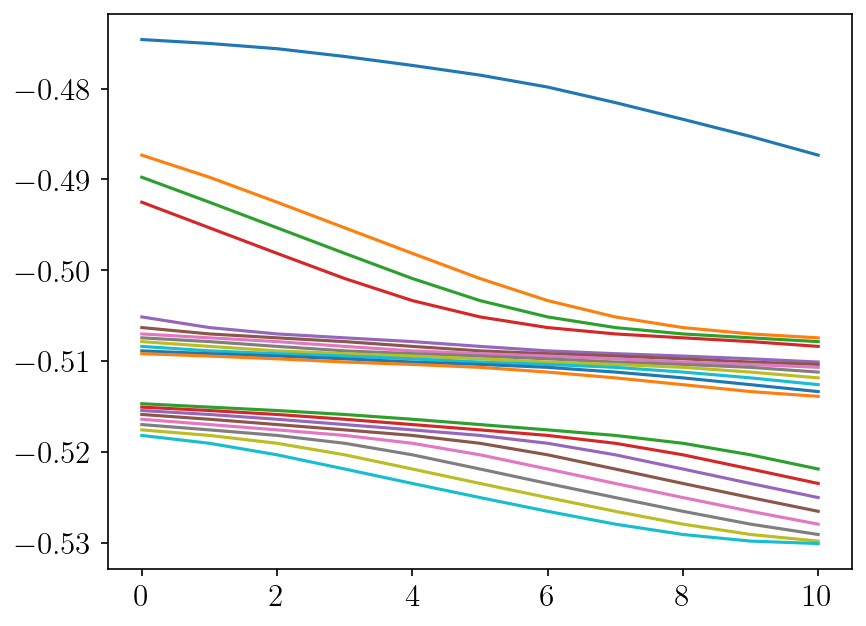

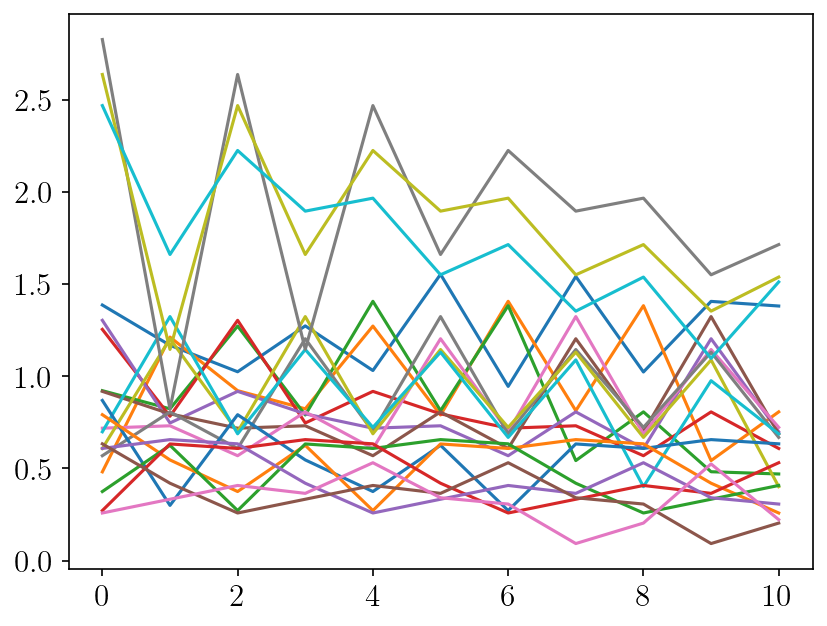

In [33]:
for i in range(20):
    plt.plot(ENSOstate[i])
plt.show()

for i in range(20):
    RMMamp = np.sqrt((RMM1state[i]**2) + (RMM2state[i]**2))
    plt.plot(RMMamp)
plt.show()